In [1]:
# Basic Vocab
# Observations/Instances/Samples/Examples
# Target Variable
# Supervised vs Unsupervised

In [2]:
# Here, we import required libraries and our raw training data.

# Numerical analysis
import numpy as np

# Data manipulation
import pandas as pd
import string

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Import training data. "df" is short here for "data frame" (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).
df = pd.read_csv('twitter.csv')

In [3]:
# Run this to see basic metadata describing the structure of our raw training data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [4]:
# Run this for some basic statistics on our raw training data.
df.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


<Axes: ylabel='Frequency'>

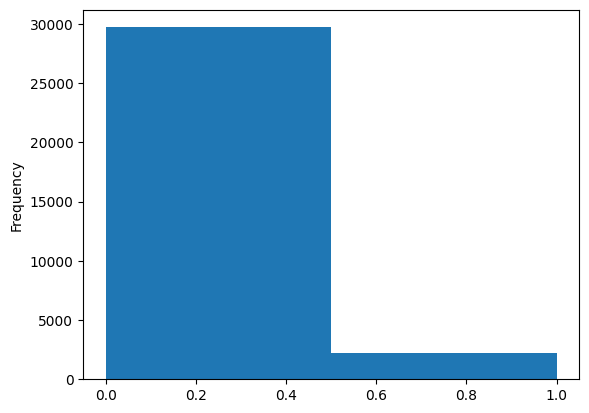

In [5]:
# Plot the histogram of the class column
df['label'].plot(bins=2,kind = 'hist')

In [6]:
positive = df[df['label']==0]
negative = df[df['label']==1]

In [7]:
sentences = df['tweet'].tolist()


In [8]:
combined = " ".join(sentences)

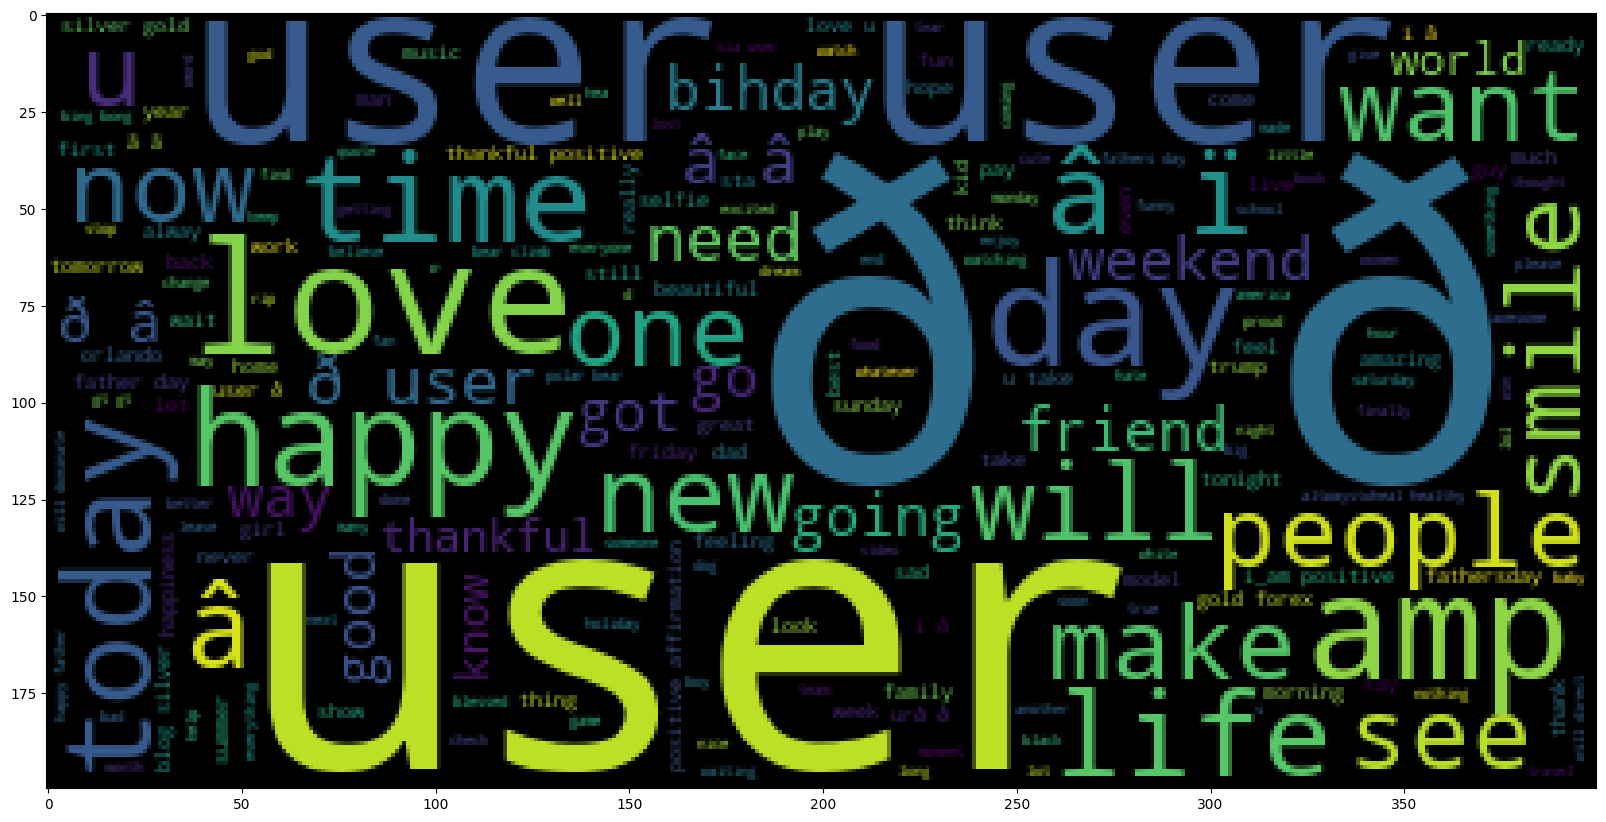

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(combined))
# Show cloud for gendered and non-gendered separation.

In [10]:
# Natural language toolkit
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Tuning a model via pre-processing steps in a pipeline.
#
# It is important to keep a CLEAN dataset.
# Here, we can use our common sense to realize that the "ID" column in our data and punctuation are not relevant in predicting whether a statement has gender bias or not.
# Removing extraneous data will strengthen the predictive capability of a model. Let's think about this in a more practical example:
# When we determine what color a cup is, does the time of day matter? Or the volume on the TV in the background? We want to only focus on the cup and lighting.

# Drop unnecessary column.
df = df.drop(['id'], axis=1)


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# What else can we do? Drop punctuation.

# Give examples then show definition of main pipeline. Programming details are not as important to teach here.
# Basic, basic explanation of what a function is/does.
def removePunctuation(msg):
    msgSansPunctuation = [char for char in msg if char not in string.punctuation]
    result = ''.join(msgSansPunctuation)
    return result



In [12]:
# Then do the actual code.
def removeStopWords(msg, stopwordsList):
    return [word for word in msg.split() if word.lower() not in stopwordsList]

# Explore the stopwords. Notice that some gendered terms are being removed, which we very much care about. What do you think should/shouldn't be a stopword?
# *** Try processing the data with base stop words and a smaller subset. Do we get different results? 
# new_stopwords = set(stopwords.words('english')) - {'this', 'these'}

In [13]:
# Define pipeline
def pipeline(msg):
    noPunct = removePunctuation(msg)
    result = removeStopWords(noPunct, stopwords.words('english'))
    return result

df_clean = df['tweet'].apply(pipeline)

In [14]:
print(df_clean[5])
print(df['tweet'][5])

['22', 'huge', 'fan', 'fare', 'big', 'talking', 'leave', 'chaos', 'pay', 'disputes', 'get', 'allshowandnogo']
[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo  


In [15]:
# Tokenization (Count Vectoring)
from sklearn.feature_extraction.text import CountVectorizer

# Basic explanation of what it is, maybe an easy example.
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# min/max_df
# dtype: type of the matrix returned; really only needs to be large if an example has potential to have a VERY high count of a feature (word).
vectorizer = CountVectorizer(analyzer = pipeline, dtype = np.uint8)
# wtf does this do
input_countVectorizer = vectorizer.fit_transform(df['tweet'])

# words



In [16]:
X = pd.DataFrame(input_countVectorizer.toarray())

In [17]:
Y = df['label']

In [18]:
# Prior probability (total in dataset)
# Defined as # of sa in class / total number of examples
# Likelihood (proximity feature-wise to classified data points) (K-NNish? I think it's more about a defined range of proximity than the # of neighbors as far as constraints go.)
# Defined as # in vicinity / total in class
# Bayes' Theorem combines both: Posterior Prob = Prior Prob * Likelihood. Higher prob = decision.
# P(Outcome | Sample Features)  = P(Outcome) * P(Sample Features | Outcome) / P(Sample Features)

In [19]:
from sklearn.model_selection import train_test_split
# 40% testing, 60% training
# NOTE: Likely due to container resource restraints, test_size at a sufficiently small value will cause the kernel to crash.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.4)


In [20]:
from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, Y_train)

MultinomialNB()

In [21]:
# Confusion Matrix
#              TRUE CLASS
# P            +                -
# R   +     TRUE +           FALSE + (Type 1 error)
# E   -     FALSE - type 2   TRUE -
# D

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

<Axes: >

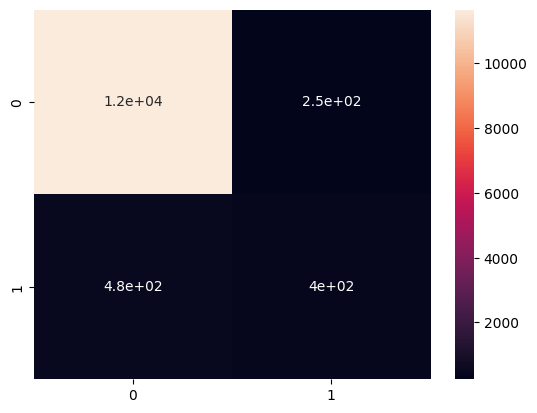

In [23]:
Y_predict_test = NB_classifier.predict(X_test)
cm = confusion_matrix(Y_test, Y_predict_test)
sns.heatmap(cm, annot=True)

In [24]:
print(classification_report(Y_test, Y_predict_test))
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support
# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label a negative sample as positive.
# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
# The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.
# The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important. Beta defaults to 1.0 here.
# Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     11902
           1       0.62      0.46      0.52       883

    accuracy                           0.94     12785
   macro avg       0.79      0.72      0.75     12785
weighted avg       0.94      0.94      0.94     12785

